In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
file_path = 'weather.csv'
data=pd.read_csv(file_path, delimiter=',',header=11,skipinitialspace=True)
data.head(24)

,Year,Month,Day,Hour,Minute,Temperature,Total_Precipitation,Wind_Speed,Wind_Direction
0,2021,11,22,0,0,23.471820,0.0,6.73,74.48
1,2021,11,22,1,0,23.551820,0.0,6.62,67.62
2,2021,11,22,2,0,23.421822,0.0,6.30,59.04
3,2021,11,22,3,0,22.891820,0.0,6.30,59.04
4,2021,11,22,4,0,22.351822,0.0,6.19,54.46
5,2021,11,22,5,0,21.491821,0.0,5.90,52.43
6,2021,11,22,6,0,20.641820,0.0,5.86,47.49
7,2021,11,22,7,0,19.831821,0.0,5.60,45.00
8,2021,11,22,8,0,19.231821,0.0,6.62,45.00
9,2021,11,22,9,0,18.591822,0.0,6.37,47.29


In [24]:
temperature = np.array(data['Temperature'])
num_periods = 24
f_horizon = 1
x_data = temperature[:(len(temperature)-(num_periods*2))]
x_batches = x_data.reshape(-1, num_periods, 1)

y_data = temperature[1:(len(temperature)-(num_periods*2))+f_horizon]
y_batches = y_data.reshape(-1, num_periods, 1)
print(y_batches.shape)

(13, 24, 1)


In [25]:
def test_data(series, forecast, num):
    testX = temperature[-(num + forecast):][:num].reshape(-1, num_periods, 1)
    testY = temperature[-(num):].reshape(-1, num_periods, 1)
    return testX, testY
X_test, Y_test = test_data(temperature, f_horizon, 24*2)
print(X_test.shape)


(2, 24, 1)


In [26]:
tf.compat.v1.reset_default_graph()
inputs = 1
rnn_size = 100
output = 1
learning_rate=0.001
dropout_keep_prob = tf.compat.v1.placeholder(tf.float32)

X = tf.compat.v1.placeholder(tf.float32, [None, num_periods, 1])
Y = tf.compat.v1.placeholder(tf.float32, [None, num_periods, 1])

rnn_cells=tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=rnn_size, activation=tf.nn.relu)
rnn_output, states = tf.nn.dynamic_rnn(rnn_cells, X, dtype=tf.float32)


output=tf.reshape(rnn_output, [-1, rnn_size])
logit=tf.layers.dense(output, 1, name="softmax")

outputs=tf.reshape(logit, [-1, num_periods, 1])
print(logit)

loss = tf.reduce_sum(tf.square(outputs - Y))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logit, 1), tf.cast(Y, tf.int64)), tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step=optimizer.minimize(loss)

init=tf.global_variables_initializer()

Tensor("softmax/BiasAdd:0", shape=(?, 1), dtype=float32)


In [27]:
epochs = 1000

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
saver = tf.train.Saver()

for epoch in range(epochs):
    train_dict = {X: x_batches, Y: y_batches, dropout_keep_prob:0.5}
    sess.run(train_step, feed_dict=train_dict)
y_pred=sess.run(outputs, feed_dict={X: X_test})
save_path = saver.save(sess, "models/weather.ckpt")

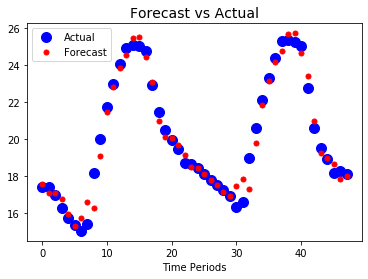

In [28]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=10, label="Forecast")
plt.legend(loc="upper left")
plt.xlabel("Time Periods")
plt.show()

In [29]:
print(Y_test)
print("")
print(y_pred)

[[[17.401821]
  [17.401821]
  [16.981821]
  [16.30182 ]
  [15.73182 ]
  [15.39182 ]
  [15.05182 ]
  [15.40182 ]
  [18.191822]
  [20.021822]
  [21.741821]
  [22.981821]
  [24.061821]
  [24.95182 ]
  [25.091822]
  [25.04182 ]
  [24.78182 ]
  [22.911821]
  [21.481821]
  [20.511822]
  [19.96182 ]
  [19.46182 ]
  [18.72182 ]
  [18.691822]]

 [[18.431822]
  [18.14182 ]
  [17.811821]
  [17.54182 ]
  [17.28182 ]
  [16.941822]
  [16.351822]
  [16.611822]
  [19.001822]
  [20.62182 ]
  [22.14182 ]
  [23.331821]
  [24.401821]
  [25.311821]
  [25.37182 ]
  [25.28182 ]
  [25.021822]
  [22.771822]
  [20.63182 ]
  [19.54182 ]
  [18.941822]
  [18.191822]
  [18.271822]
  [18.101822]]]

[[[17.591354]
  [17.119246]
  [17.089283]
  [16.77848 ]
  [15.96326 ]
  [15.308288]
  [15.772622]
  [16.635214]
  [16.287218]
  [19.111847]
  [21.449123]
  [22.845858]
  [23.84258 ]
  [24.575743]
  [25.481619]
  [25.540396]
  [24.44631 ]
  [23.076216]
  [20.980104]
  [20.121622]
  [20.081345]
  [19.699749]
  [19.171087]
 